In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from astropy.table import Table
from desitarget.targetmask import desi_mask
import os 
%matplotlib inline

In [13]:
datapath = "/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/"
tiles = glob.glob(datapath+"*.fits")
print('Total numer of tiles:', len(tiles))

Total numer of tiles: 7098


In [30]:
def count_targets(tilefile):
    
    tileid = int(tilefile.split('_')[-1].split('.')[0])
    
    # mask for sky targets
    sky_mask = desi_mask.SKY
    badsky_mask = desi_mask.BAD_SKY
    
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # This is the field with the assignments
    assigned = Table.read(tilefile, 'FIBERASSIGN')
    
    # This is the field with the potential assigments
    potential = Table.read(tilefile, 'POTENTIAL')

    # Unassigned fibers have TARGETID==-1
    nassigned = len(assigned)-np.count_nonzero(assigned['TARGETID']==-1)
    
    # find whether a sky or stdstar target has been assigned
    nstd = np.count_nonzero(assigned['DESI_TARGET'] & std_mask)
    nsky = np.count_nonzero(assigned['DESI_TARGET'] & sky_mask)
    nbadsky = np.count_nonzero(assigned['DESI_TARGET'] & badsky_mask)

    npotential = len(potential)

    # the number of science targets assigned
    nscience = nassigned - nstd - nsky - nbadsky
    
    
    return {'tileid':tileid,
            'RA':np.median(assigned['TARGET_RA']),
            'DEC':np.median(assigned['TARGET_DEC']),
            'npotential':npotential, 'nscience':nscience, 'nstd':nstd, 'nsky':nsky, 'nbadsky':nbadsky}

In [34]:
if not os.path.isfile('tile_counts.txt'):
    n_tiles = len(tiles)
    count_all = {}
    for i in range(n_tiles):
        count_all[i] = count_targets(tiles[i])
        if not(i % (n_tiles//100)):
            print("{:}%  ".format(int(100.0*i/n_tiles)), end="\b")

0% 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 

In [35]:
def write_counts(count_all, outfile = 'tile_counts.txt'):
    f  = open(outfile, 'w')
    f.write("# TILEID RA DEC NSKY NBADSKY NSTD NSCIENCE NPOTENTIAL\n")
    n_tiles = len(count_all)
    for i in range(n_tiles):
        f.write("{:d}\t".format(count_all[i]['tileid']))
        f.write("{:.2f}\t".format(count_all[i]['RA']))
        f.write("{:.2f}\t".format(count_all[i]['DEC']))
        f.write("{:d}\t".format(count_all[i]['nsky']))
        f.write("{:d}\t".format(count_all[i]['nbadsky']))
        f.write("{:d}\t".format(count_all[i]['nstd']))
        f.write("{:d}\t".format(count_all[i]['nscience']))
        f.write("{:d}\t".format(count_all[i]['npotential']))
        f.write("\n")
    f.close()

In [36]:
if not os.path.isfile('tile_counts.txt'):
    write_counts(count_all)

In [38]:
counts = Table.read('tile_counts.txt', format='ascii')
counts['NUSED'] = counts['NSKY'] + counts['NSTD'] + counts['NSCIENCE'] + counts['NBADSKY']

In [39]:
def plot_footprint(counts, field = 'SCIENCE', limit=5000, threshold='above'):
    c = counts['N'+field]

    plt.figure(figsize=(10,6))
    plt.rc('text', usetex=False,)
    plt.rc('font', family='serif', size=18)
    if threshold=='above':
        ii = c > limit
        title = '# of tiles with more than {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold=='below':
        ii = c < limit
        title = '# of tiles with less than {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold=='exact':
        ii = c == limit
        title = '# of tiles with exactly {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold == 'all':
        ii = np.arange(len(c))
        title = '# of tiles : {}'.format(len(ii))

            
    plt.scatter(counts['RA'][ii], counts['DEC'][ii], c=c[ii], alpha=0.5)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    
    label =  " {} fibers per tile".format(field.lower())
    plotname = 'doc/assigned_{}_ra_dec_{}.pdf'.format(field.lower(), threshold)
    
    plt.colorbar(label = label)
    plt.title(title)
    plt.savefig(plotname, bbox_inches='tight')

In [48]:
def plot_single_tile(tilefile):
    tileid = int(tilefile.split('_')[-1].split('.')[0])
    
    plt.figure(figsize=(15,14))
    plt.rc('text', usetex=False,)
    plt.rc('font', family='serif', size=15)

    assigned = Table.read(tilefile, 'FIBERASSIGN')
    gfa = Table.read(tilefile, 'GFA')
    skyetc = Table.read(tilefile, 'SKYETC')

    # mask for sky targets
    sky_mask = desi_mask.SKY
    badsky_mask = desi_mask.BAD_SKY
        
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # find whether a sky or stdstar target has been assigned
    ii_sky = (assigned['DESI_TARGET'] & sky_mask)!=0
    ii_badsky = (assigned['DESI_TARGET'] & badsky_mask)!=0
    ii_std = (assigned['DESI_TARGET'] & std_mask)!=0

    
    # min max
    minra = assigned['TARGET_RA'].min()
    maxra = assigned['TARGET_RA'].max()
    mindec = assigned['TARGET_DEC'].min()
    maxdec = assigned['TARGET_DEC'].max()
    
    plt.subplot(2,2,1)
    plt.scatter(assigned['TARGET_RA'][ii_sky], assigned['TARGET_DEC'][ii_sky], s=1.0, label='{} SKY fibers'.format(np.count_nonzero(ii_sky)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])

    plt.subplot(2,2,2)
    plt.scatter(assigned['TARGET_RA'][ii_std], assigned['TARGET_DEC'][ii_std], s=1.0, label='{} STD fibers'.format(np.count_nonzero(ii_std)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])
    
    plt.subplot(2,2,3)
    plt.scatter(assigned['TARGET_RA'][ii_badsky], assigned['TARGET_DEC'][ii_badsky], s=1.0, label='{} BADSKY fibers'.format(np.count_nonzero(ii_badsky)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])

#    ii = skyetc['TARGETID']>0
#    plt.subplot(2,2,3)
#    plt.scatter(gfa['RA'], gfa['DEC'], s=10.0, label='GFA')
#    plt.scatter(skyetc['RA'][ii], skyetc['DEC'][ii], s=10.0, label='SKYETC')
#    plt.xlabel('RA [deg]')
#    plt.ylabel('DEC [deg]')
#    plt.xlim([minra, maxra])
#    plt.ylim([mindec, maxdec])
#    plt.legend()

    plt.subplot(2,2,4)
    ii_science = (assigned['TARGETID'] > 0) & (~(ii_sky|ii_std|ii_badsky) )
    print(np.count_nonzero(ii_science))
    plt.scatter(assigned['TARGET_RA'][ii_science], assigned['TARGET_DEC'][ii_science], s=1.0, label='{} SCIENCE fibers'.format(np.count_nonzero(ii_science)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])
    plt.savefig('doc/single_tile_{}.pdf'.format(tileid), bbox_inches='tight')

919


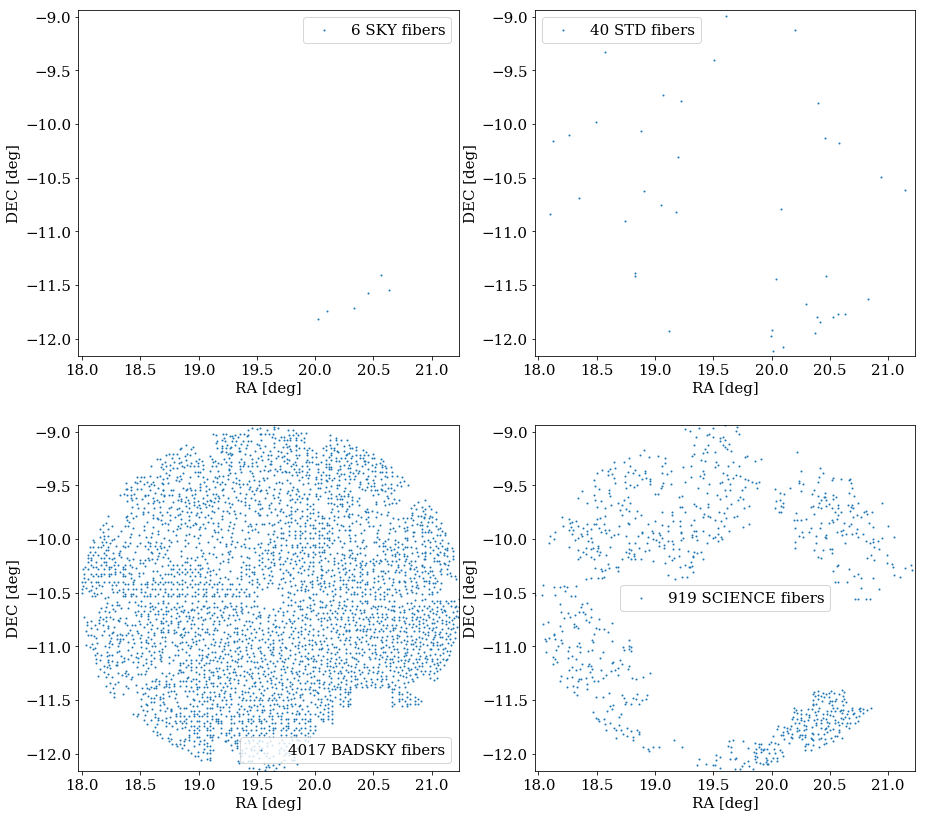

In [49]:
tilefile = "/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_00589.fits"
plot_single_tile(tilefile)

TILEID   RA    DEC  NSKY NBADSKY NSTD NSCIENCE NPOTENTIAL NUSED
------ ------ ----- ---- ------- ---- -------- ---------- -----
  1858 120.12 34.46   42    1625   40      784      13105  2491
  6854   4.59 30.67    1    2212   16      265      10098  2494
[ '/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_01858.fits'
 '/global/cscratch1/sd/forero/testfiber/dark_large/fiber_output/tile_06854.fits']
784
265


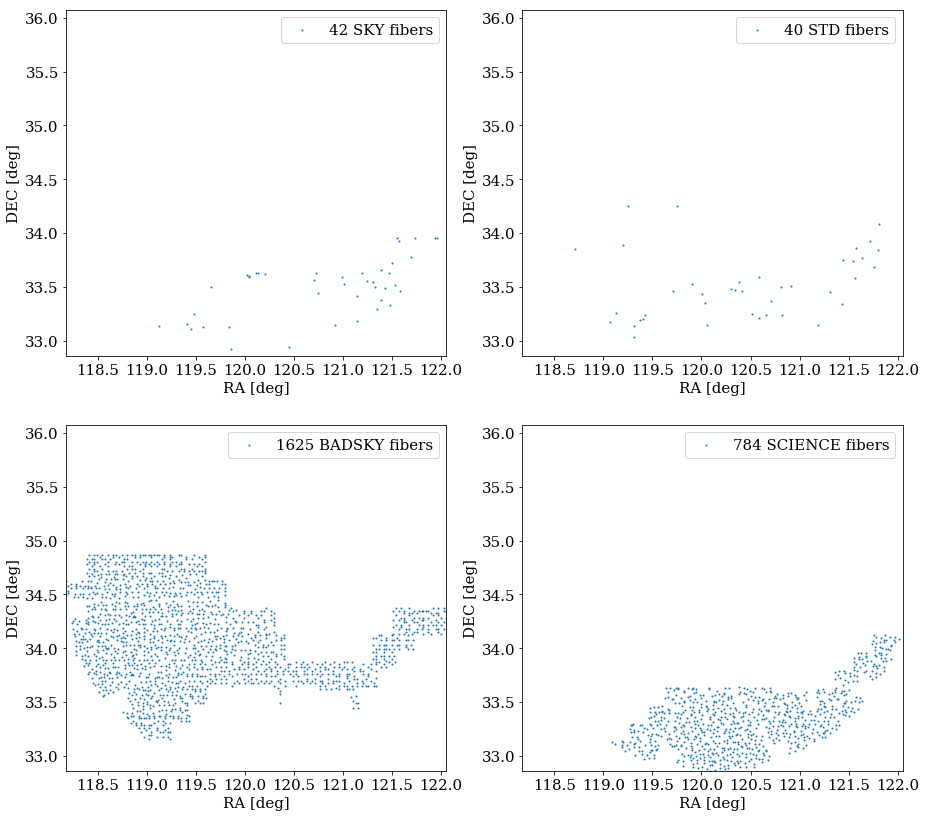

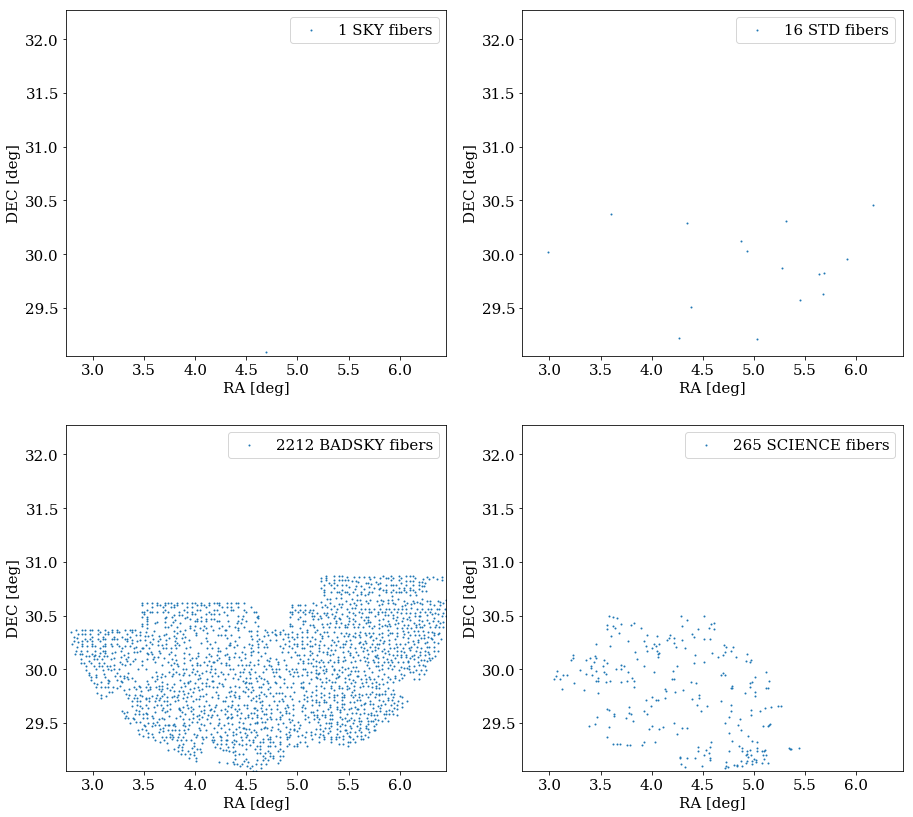

In [52]:
ii = (counts['NUSED']>2490) & (counts['NUSED']<2500)
print(counts[ii])
print(np.array(tiles)[ii])

plot_single_tile(np.array(tiles)[ii][0])
plot_single_tile(np.array(tiles)[ii][1])

TILEID   RA    DEC  NSKY NBADSKY NSTD NSCIENCE NPOTENTIAL NUSED
------ ------ ----- ---- ------- ---- -------- ---------- -----
  9042 216.54  35.2  148     501   52     1756      19679  2457
   778 254.11 34.95  108     845   46     1466      18958  2465
 23854 244.14 34.41  158     656   40     1167      13910  2021
 24176 162.16 34.63   41    2351   15       26       9348  2433
 24117  14.85 30.65  526     475   59     1316      15607  2376
 18079  251.7 35.54  134     759   50     1456      18895  2399
 18385   3.24 30.72    0    2018   16       30       8253  2064
 18451 153.95 33.79  144     331   50     1941      22341  2466
  6568 240.95 34.46   19    1806   35      582      13206  2442
 18434 157.49 34.28   55    1684   29      706      13815  2474
   ...    ...   ...  ...     ...  ...      ...        ...   ...
 13382 122.31 34.43  180     899   32     1129      14576  2240
  6577 235.17 34.41   16    1820   31      354      10551  2221
  3221 202.19 34.72   10    2225   23   

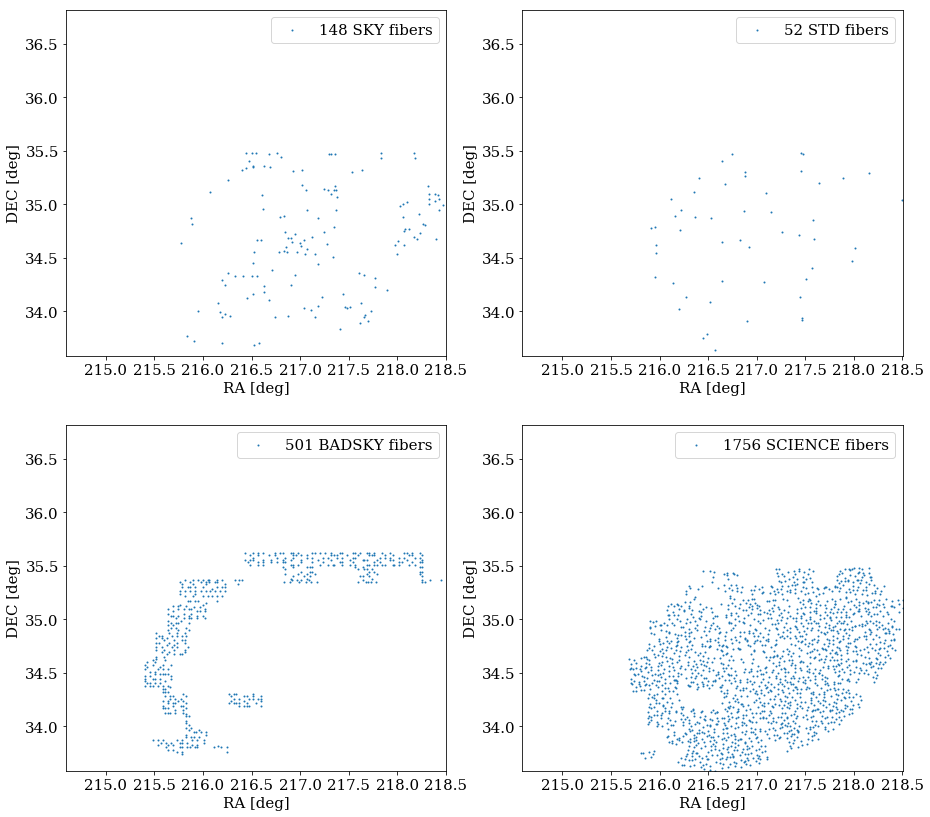

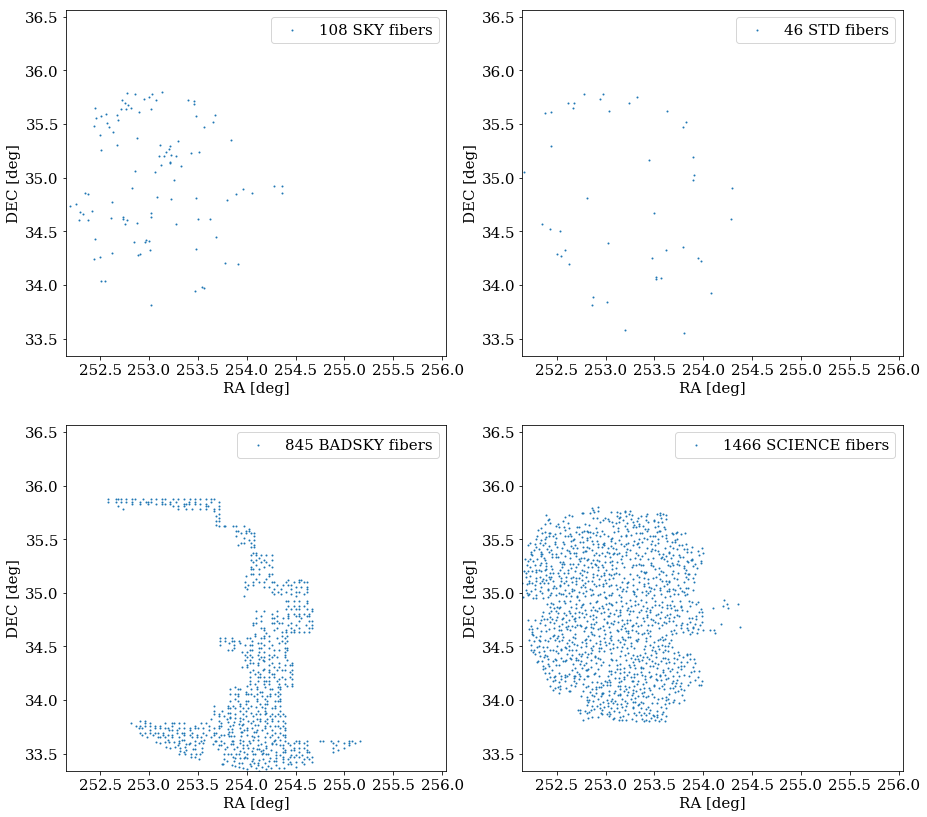

In [63]:
ii = (counts['NUSED']>2000) & (counts['NUSED']<2500)
print(counts[ii])
print(np.array(tiles)[ii])

plot_single_tile(np.array(tiles)[ii][0])
plot_single_tile(np.array(tiles)[ii][1])

2447


Text(0,0.5,'Y [mm]')

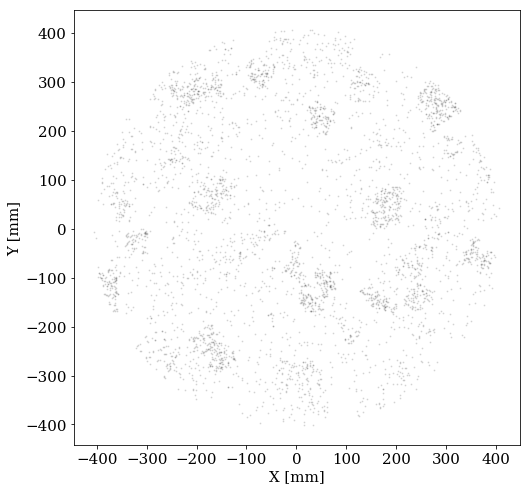

In [54]:
plt.figure(figsize=(8,8))
plt.rc('text', usetex=False,)
plt.rc('font', family='serif', size=15)
ii = (counts['NUSED']==5000) & (counts['NSCIENCE']==4500) & (counts['NSKY']==400)
print(np.count_nonzero(ii))
#print(np.array(tiles)[ii])
for tilefile in np.array(tiles)[ii][0:10]:
    assigned = Table.read(tilefile, 'FIBERASSIGN')
    # mask for sky targets
    sky_mask = desi_mask.SKY    
    ii_sky = (assigned['DESI_TARGET'] & sky_mask)!=0
    
    plt.scatter(assigned['DESIGN_X'][ii_sky], assigned['DESIGN_Y'][ii_sky], s=1.0, color='black', alpha=0.1)
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')

2457


Text(0,0.5,'Y [mm]')

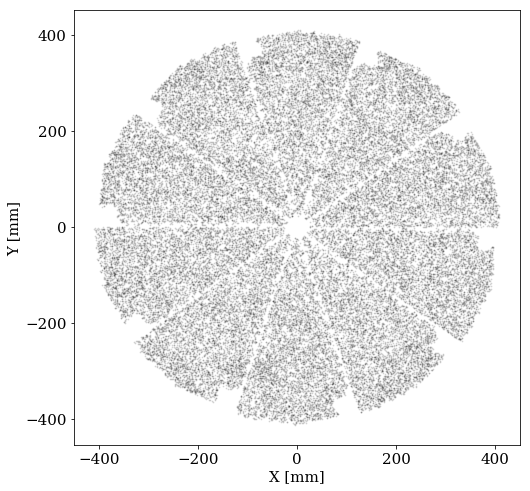

In [163]:
plt.figure(figsize=(8,8))
plt.rc('text', usetex=False,)
plt.rc('font', family='serif', size=15)
ii = (counts['NUSED']==5000) & (counts['NSCIENCE']==4500) & (counts['NSTD']==100)
print(np.count_nonzero(ii))
#print(np.array(tiles)[ii])
for tilefile in np.array(tiles)[ii][0:500]:
    assigned = Table.read(tilefile, 'FIBERASSIGN') 
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # find whether a sky or stdstar target has been assigned
    ii_std = (assigned['DESI_TARGET'] & std_mask)!=0
    
    plt.scatter(assigned['DESIGN_X'][ii_std], assigned['DESIGN_Y'][ii_std], s=1.0, color='black', alpha=0.1)
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')

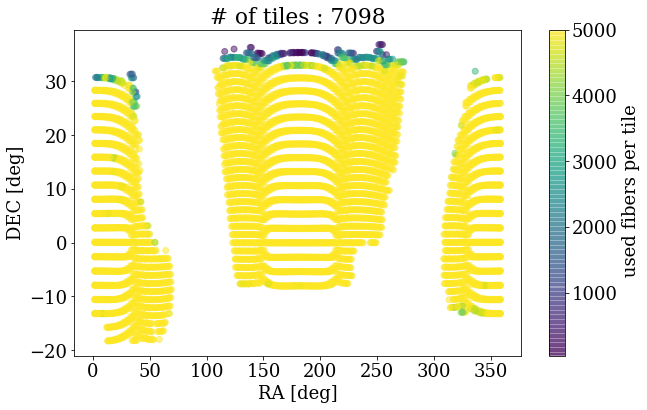

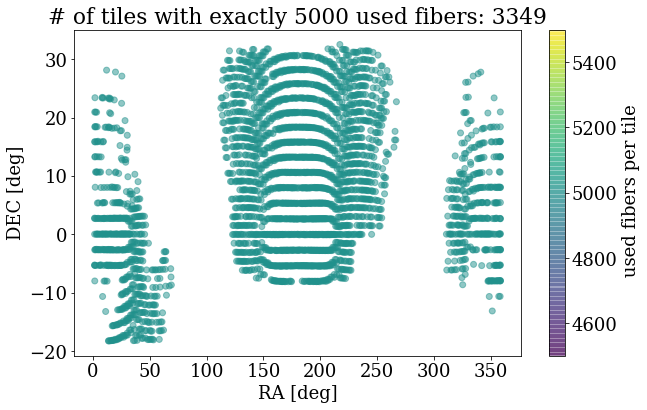

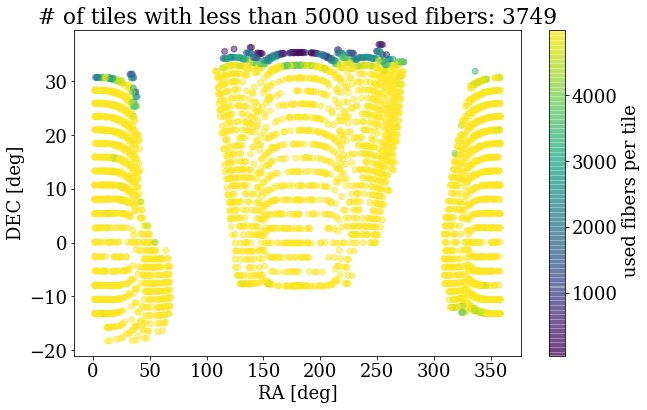

In [55]:
plot_footprint(counts, field='USED', limit=5000, threshold='all')
plot_footprint(counts, field='USED', limit=5000, threshold='exact')
plot_footprint(counts, field='USED', limit=5000, threshold='below')

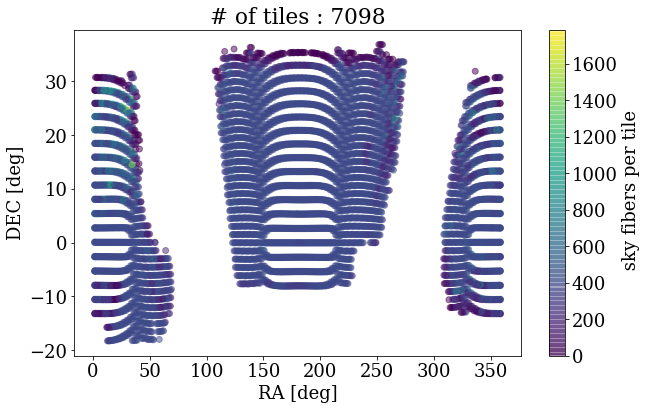

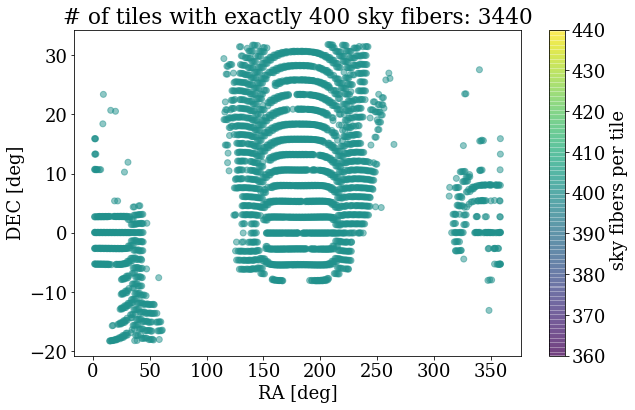

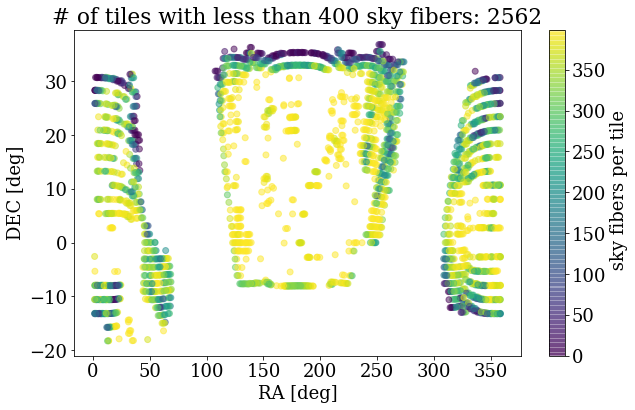

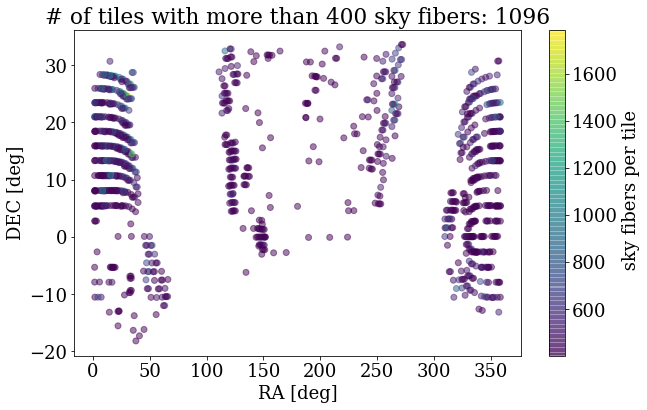

In [56]:
plot_footprint(counts, field='SKY', limit=400, threshold='all')
plot_footprint(counts, field='SKY', limit=400, threshold='exact')
plot_footprint(counts, field='SKY', limit=400, threshold='below')
plot_footprint(counts, field='SKY', limit=400, threshold='above')

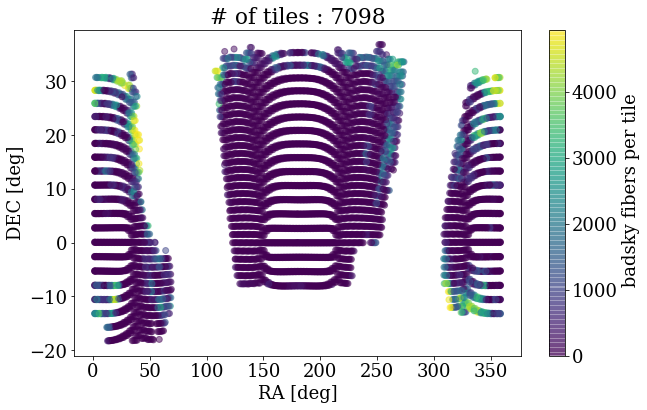

In [57]:
plot_footprint(counts, field='BADSKY', limit=400, threshold='all')

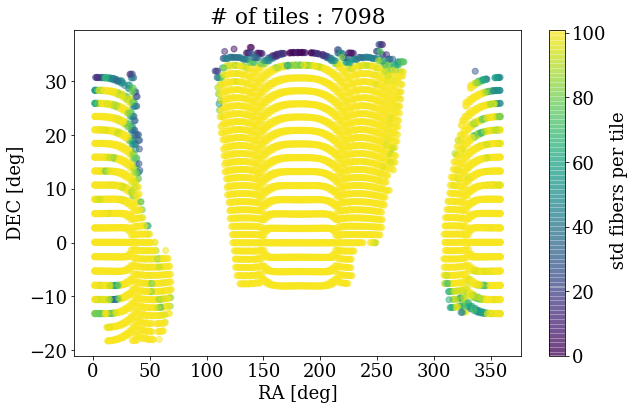

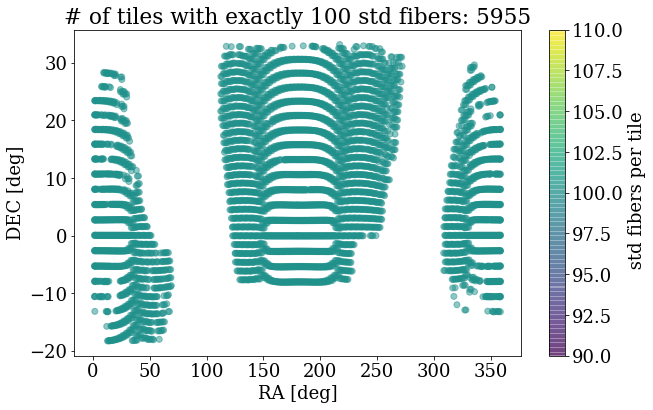

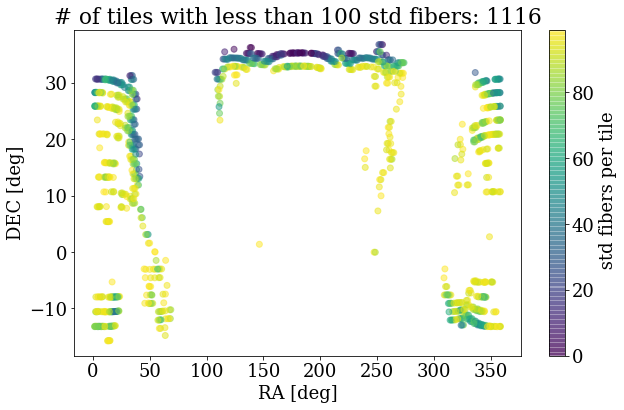

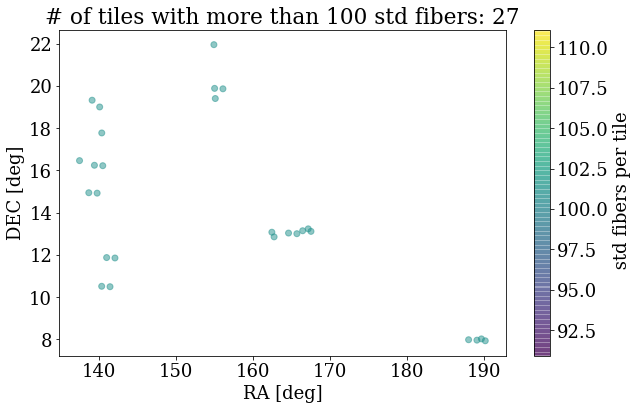

In [58]:
plot_footprint(counts, field='STD', limit=100, threshold='all')
plot_footprint(counts, field='STD', limit=100, threshold='exact')
plot_footprint(counts, field='STD', limit=100, threshold='below')
plot_footprint(counts, field='STD', limit=100, threshold='above')

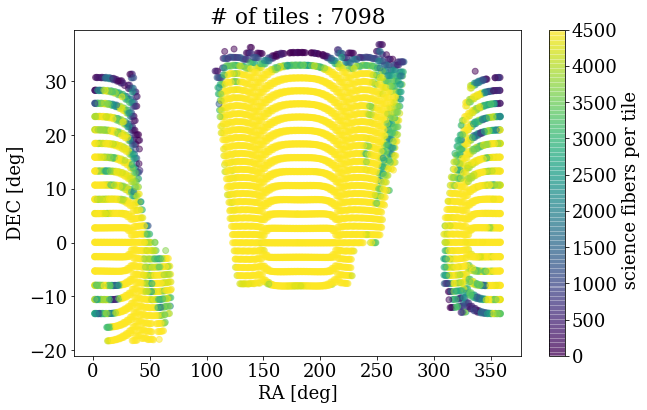

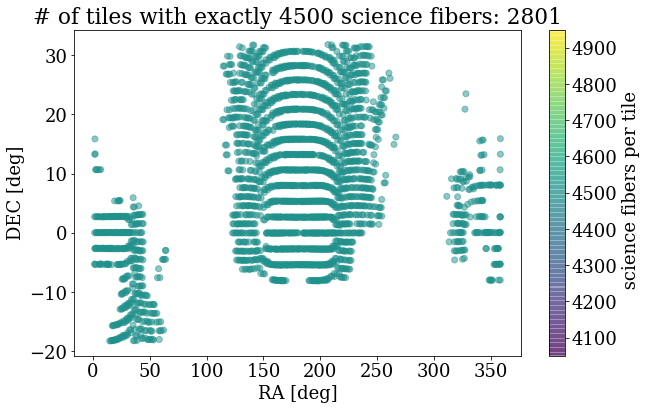

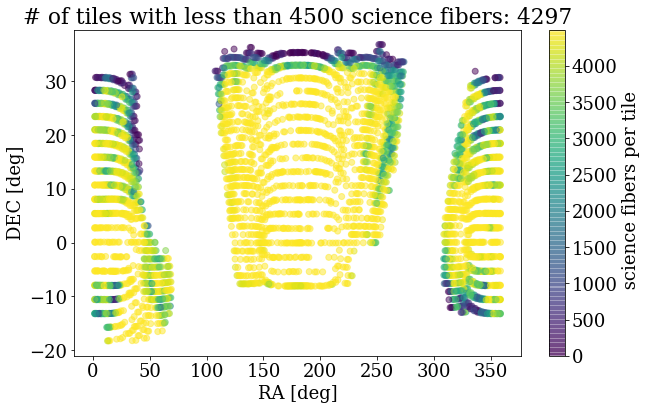

In [60]:
plot_footprint(counts, field='SCIENCE', limit=4500, threshold='all')
plot_footprint(counts, field='SCIENCE', limit=4500, threshold='exact')
plot_footprint(counts, field='SCIENCE', limit=4500, threshold='below')

In [61]:
plt.figure(figsize=(17,12))

ii = (all_dec < 20) & (all_dec >-5)
all_used = all_science+all_sky+all_std
plt.subplot(2,2,1)
n = np.int(np.mean(all_used[ii]))
s = np.int(np.std(all_used[ii]))
_ = plt.hist(all_used[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of used fibers')
plt.legend()


plt.subplot(2,2,2)
n = np.int(np.mean(all_science[ii]))
s = np.int(np.std(all_science[ii]))
_ = plt.hist(all_science[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of science fibers')
plt.legend()



plt.subplot(2,2,3)
n = np.int(np.mean(all_sky[ii]))
s = np.int(np.std(all_sky[ii]))
_ = plt.hist(all_sky[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of sky fibers')
plt.ylabel('Number of tiles')

plt.legend()


plt.subplot(2,2,4)
n = np.int(np.mean(all_std[ii]))
s = np.int(np.std(all_std[ii]))
_ = plt.hist(all_std[ii], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of stdstar fibers')
plt.ylabel('Number of tiles')

plt.legend()
plt.savefig('doc/used_fibers.pdf', bbox_inches='tight')

NameError: name 'all_dec' is not defined

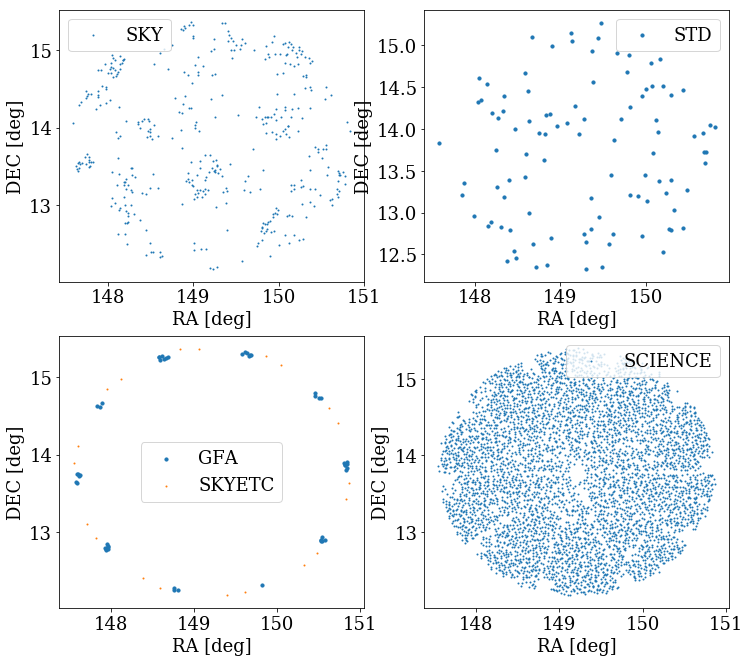

In [250]:
np.count_nonzero(ii)

3884

In [251]:
4996/5000.0

0.9992